# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [233]:
import sys
# sys.path.append('..')

from pathlib import Path

import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [234]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [235]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,41.0
2,adventuregame,Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B...,0_home_deliver_three_basic_easy,episode_0,Request Count,41.0
3,adventuregame,Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,1.0
...,...,...,...,...,...,...
26235,adventuregame,Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-...,7_home_deliver_three_planning_hard_invlimittwo,episode_5,Played,1.0
26236,adventuregame,Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-...,7_home_deliver_three_planning_hard_invlimittwo,episode_6,Played,1.0
26237,adventuregame,Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-...,7_home_deliver_three_planning_hard_invlimittwo,episode_7,Played,1.0
26238,adventuregame,Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-...,7_home_deliver_three_planning_hard_invlimittwo,episode_8,Played,1.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [236]:
model_name_dict = {
    'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-GGUF-q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B-Instruct",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B-Instruct',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B-Instruct',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B-Instruct'
}

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '3_home_deliver_three_planning_easy_invlimittwo': "planning-easy-invlimit",
    '4_home_deliver_three_basic_hard': "basic-hard",
    '5_home_deliver_three_planning_hard': "planning-hard",
    '6_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '7_home_deliver_three_planning_hard_invlimittwo': "planning-hard-invlimit"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [237]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Parsed Request Count,41.0
2,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Request Count,41.0
3,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,hallucination_count,1.0
...,...,...,...,...,...,...
26235,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.0
26236,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.0
26237,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.0
26238,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_8,Played,1.0


## Overall benchmark scores

In [238]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [239]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Llama-3-8B-Instruct,10.84,57.81,18.75,30.95,57.81,18.75
Llama-3.1-8B-Instruct,39.06,100.00,39.06,41.22,100.00,39.06
Qwen2.5-7B-Instruct,11.57,94.53,12.24,25.40,94.53,12.24
openchat3.5-GGUF-q8,14.40,93.75,15.36,29.55,93.75,15.36
openchat3.5,12.63,89.84,14.06,28.25,89.84,14.06


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [240]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score,Quality Score (std)
Llama-3.1-8B-Instruct,39.06,100.00,39.06,41.22
openchat3.5-GGUF-q8,14.40,93.75,15.36,29.55
openchat3.5,12.63,89.84,14.06,28.25
Qwen2.5-7B-Instruct,11.57,94.53,12.24,25.40
Llama-3-8B-Instruct,10.84,57.81,18.75,30.95


In [241]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [242]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=2).format(subset="% Played", precision=2).format(subset="Quality Score", precision=2).format(subset="Quality Score (std)", precision=2)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

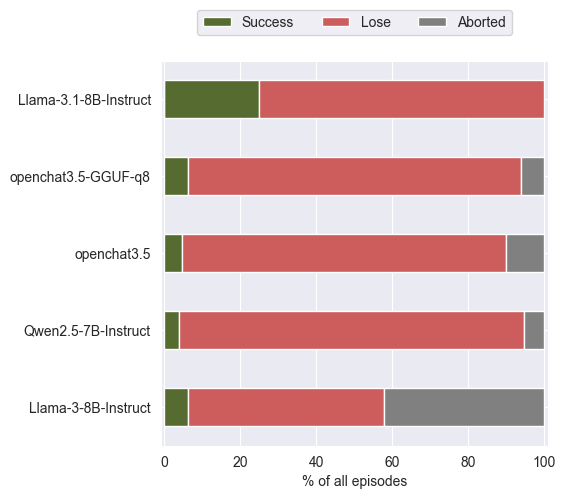

In [243]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]
df_aux = df_aux.replace(model_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with sorted clemscores:

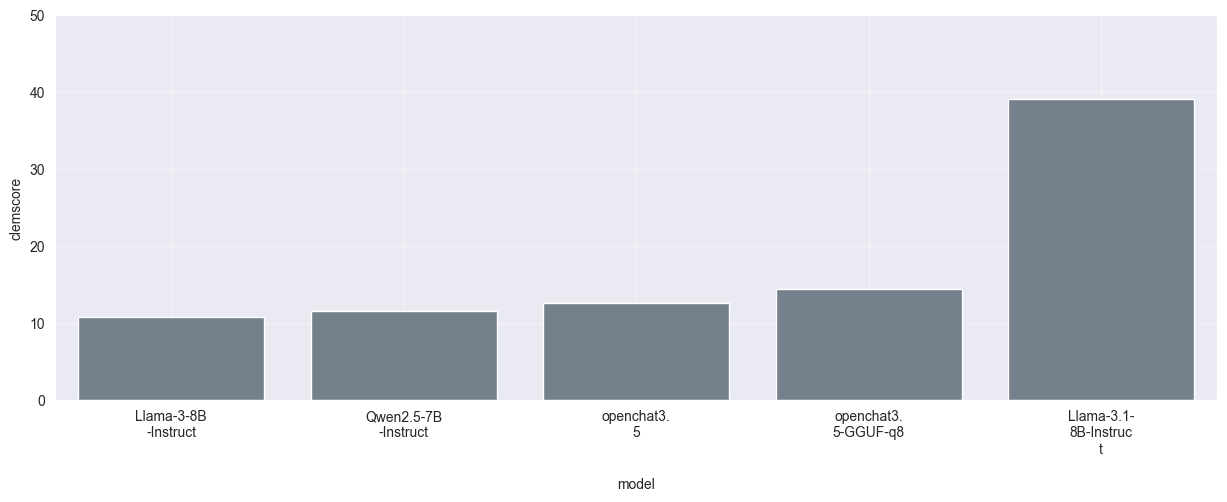

In [244]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 50)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [245]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Parsed Request Count,41.0
2,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Request Count,41.0
3,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,hallucination_count,1.0
...,...,...,...,...,...,...
26235,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.0
26236,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.0
26237,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.0
26238,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_8,Played,1.0


## Failure metrics
### Failures by IF interpreter phase

In [246]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,action_resolution_fail,12.0
45,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_1,action_parsing_fail,0.0
46,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_1,action_resolution_fail,6.0
85,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_10,action_parsing_fail,1.0
...,...,...,...,...,...,...
25486,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_7,action_resolution_fail,9.0
25525,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_8,action_parsing_fail,0.0
25526,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_8,action_resolution_fail,25.0
25565,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_9,action_parsing_fail,5.0


Bar plot showing failures by phase for all models over all experiments:

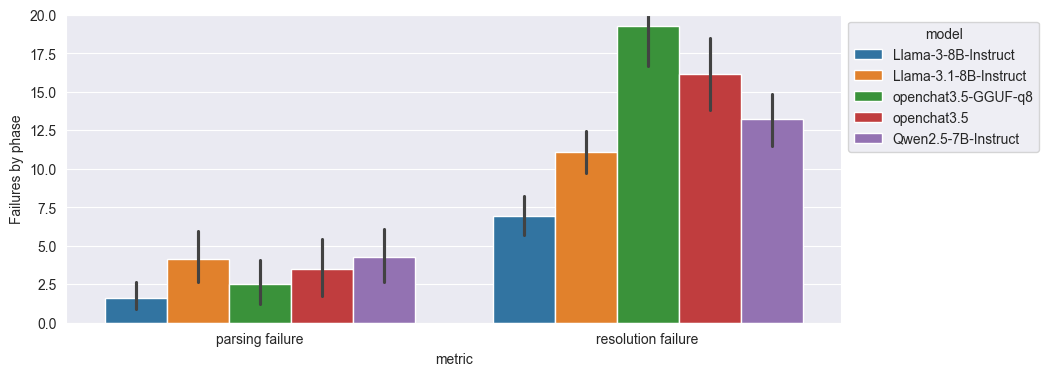

In [247]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 20)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [248]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Llama-3-8B-Instruct,2789.0
Llama-3.1-8B-Instruct,4888.0
Qwen2.5-7B-Instruct,5651.0
openchat3.5,4508.0
openchat3.5-GGUF-q8,4822.0


Counts of failures by phase for all models over all experiments:

In [249]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model                 metric                    
Llama-3-8B-Instruct   parsing failure      208.0
                      resolution failure   885.0
Llama-3.1-8B-Instruct parsing failure      531.0
                      resolution failure  1420.0
Qwen2.5-7B-Instruct   parsing failure      545.0
                      resolution failure  1692.0
openchat3.5           parsing failure      445.0
                      resolution failure  2068.0
openchat3.5-GGUF-q8   parsing failure      323.0
                      resolution failure  2469.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [250]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model                 metric                      
Llama-3-8B-Instruct   parsing failure     0.074579
                      resolution failure  0.317318
Llama-3.1-8B-Instruct parsing failure     0.108633
                      resolution failure  0.290507
Qwen2.5-7B-Instruct   parsing failure     0.096443
                      resolution failure  0.299416
openchat3.5           parsing failure     0.098713
                      resolution failure  0.458740
openchat3.5-GGUF-q8   parsing failure     0.066985
                      resolution failure  0.512028

Overview/model comparison stacked bar plot for successful actions and failures by phase:

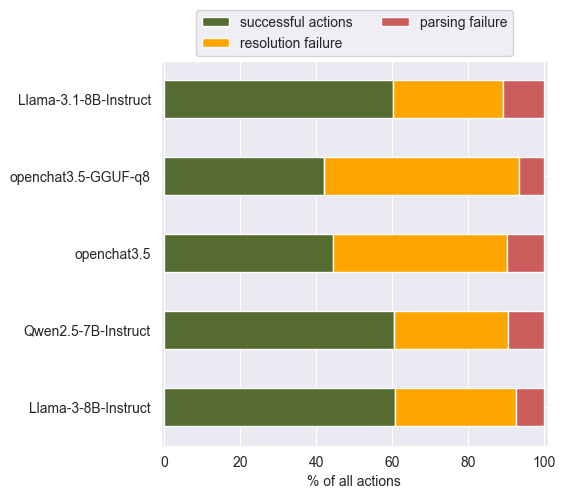

In [251]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [252]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model                 metric                                
Llama-3-8B-Instruct   malformed command       97.0  0.034779
                      out of grammar           4.0  0.001434
                      undefined action type    0.0  0.000000
                      undefined action verb   56.0  0.020079
                      undefined antecedent     0.0  0.000000
                      undefined noun          50.0  0.017928
Llama-3.1-8B-Instruct malformed command      221.0  0.045213
                      out of grammar          18.0  0.003682
                      undefined action type    0.0  0.000000
                      undefined action verb  157.0  0.032119
                      undefined antecedent     0.0  0.000000
                      undefined noun         124.0  0.025368
Qwen2.5-7B-Instruct   malformed command      217.0  0.038400
                      out of grammar           7.0  0.001239
                      undefined action type    0.0  0.000000
                      undefined action verb  176.0  0.031145
                      undefined antecedent     0.0  0.000000
                      undefined noun         110.0  0.019466
openchat3.5           malformed command        7.0  0.001553
                      out of grammar          93.0  0.020630
                      undefined action type    0.0  0.000000
                      undefined action verb  106.0  0.023514
                      undefined antecedent     0.0  0.000000
                      undefined noun         118.0  0.026176
openchat3.5-GGUF-q8   malformed command       72.0  0.014932
                      out of grammar          43.0  0.008917
                      undefined action type    0.0  0.000000
                      undefined action verb   62.0  0.012858
                      undefined antecedent     0.0  0.000000
                      undefined noun          74.0  0.015346

In [253]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

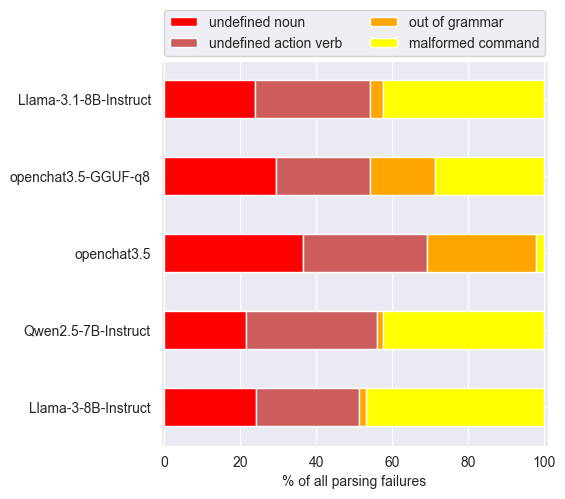

In [254]:
STACK_COLORS = ['red', 'indianred', 'orange', 'yellow']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [255]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model                 metric                                      
Llama-3-8B-Instruct   going to non-adjacent room   158.0  0.056651
                      interacting with other room    1.0  0.000359
                      manipulating room              0.0  0.000000
Llama-3.1-8B-Instruct going to non-adjacent room   306.0  0.062602
                      interacting with other room   10.0  0.002046
                      manipulating room              1.0  0.000205
Qwen2.5-7B-Instruct   going to non-adjacent room   370.0  0.065475
                      interacting with other room   27.0  0.004778
                      manipulating room              1.0  0.000177
openchat3.5           going to non-adjacent room   442.0  0.098048
                      interacting with other room  112.0  0.024845
                      manipulating room              0.0  0.000000
openchat3.5-GGUF-q8   going to non-adjacent room   331.0  0.068644
                      interacting with other room    5.0  0.001037
                      manipulating room             53.0  0.010991

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

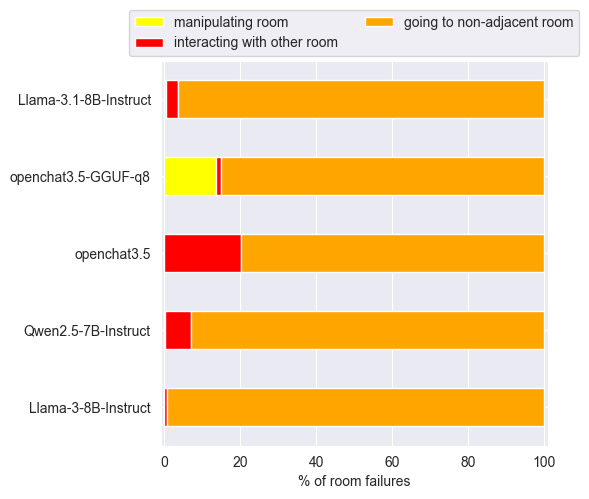

In [256]:
STACK_COLORS = ['yellow', 'orange', 'indianred', 'red', 'yellow', 'orange']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [257]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model                 metric                                       
Llama-3-8B-Instruct   entity already in inventory    10.0  0.003586
                      entity not accessible         595.0  0.213338
                      entity state mismatch           1.0  0.000359
                      entity trait mismatch           0.0  0.000000
                      inventory limit exceeded       18.0  0.006454
Llama-3.1-8B-Instruct entity already in inventory    13.0  0.002660
                      entity not accessible         773.0  0.158142
                      entity state mismatch          13.0  0.002660
                      entity trait mismatch           0.0  0.000000
                      inventory limit exceeded       38.0  0.007774
Qwen2.5-7B-Instruct   entity already in inventory    37.0  0.006548
                      entity not accessible         740.0  0.130950
                      entity state mismatch         133.0  0.023536
                      entity trait mismatch           0.0  0.000000
                      inventory limit exceeded       31.0  0.005486
openchat3.5           entity already in inventory     7.0  0.001553
                      entity not accessible        1258.0  0.279059
                      entity state mismatch          56.0  0.012422
                      entity trait mismatch           0.0  0.000000
                      inventory limit exceeded       28.0  0.006211
openchat3.5-GGUF-q8   entity already in inventory    17.0  0.003526
                      entity not accessible        1682.0  0.348818
                      entity state mismatch          84.0  0.017420
                      entity trait mismatch           0.0  0.000000
                      inventory limit exceeded       22.0  0.004562

Overview/model comparison stacked bar plot for entity-related failures:

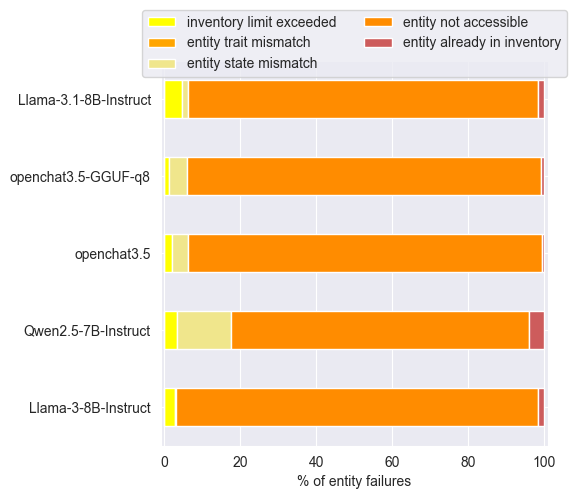

In [258]:
STACK_COLORS = ['yellow', 'orange', 'red', 'khaki', 'darkorange', 'indianred']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [259]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean  \
game          model               metric                               
adventuregame Llama-3-8B-Instruct Aborted                   0.421875   
                                  Lose                      0.515625   
                                  Main Score               18.750000   
                                  Parsed Request Count     21.789062   
                                  Played                    0.578125   
...                                                              ...   
              openchat3.5-GGUF-q8 undefined_action          0.000000   
                                  undefined_action_verb     0.484375   
                                  undefined_argument_type   0.000000   
                                  undefined_repr_str        0.578125   
                                  world_state_discrepancy   0.000000   

                                                                 std  \
game          model               metric                               
adventuregame Llama-3-8B-Instruct Aborted                   0.495799   
                                  Lose                      0.501719   
                                  Main Score               30.951660   
                                  Parsed Request Count     17.366205   
                                  Played                    0.495799   
...                                                              ...   
              openchat3.5-GGUF-q8 undefined_action          0.000000   
                                  undefined_action_verb     4.011763   
                                  undefined_argument_type   0.000000   
                                  undefined_repr_str        3.599233   
                                  world_state_discrepancy   0.000000   

                                                                  var  median  \
game          model               metric                                        
adventuregame Llama-3-8B-Instruct Aborted                    0.245817     0.0   
                                  Lose                       0.251722     1.0   
                                  Main Score               958.005249     0.0   
                                  Parsed Request Count     301.585076    19.0   
                                  Played                     0.245817     1.0   
...                                                               ...     ...   
              openchat3.5-GGUF-q8 undefined_action           0.000000     0.0   
                                  undefined_action_verb     16.094242     0.0   
                                  undefined_argument_type    0.000000     0.0   
                                  undefined_repr_str        12.954478     0.0   
                                  world_state_discrepancy    0.000000     0.0   

                                                             max  min  \
game          model               metric                                
adventuregame Llama-3-8B-Instruct Aborted                    1.0  0.0   
                                  Lose                       1.0  0.0   
                                  Main Score               100.0  0.0   
                                  Parsed Request Count      50.0  1.0   
                                  Played                     1.0  0.0   
...                                                          ...  ...   
              openchat3.5-GGUF-q8 undefined_action           0.0  0.0   
                                  undefined_action_verb     45.0  0.0   
                                  undefined_argument_type    0.0  0.0   
                                  undefined_repr_str        32.0  0.0   
                                  world_state_discrepancy    0.0  0.0   

                                                                skew  
game          model               metric                              
adventuregame Llama-3-8B-Instruct Aborted   

In [260]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean  \
game          model                 metric                              
adventuregame Llama-3-8B-Instruct   action_parsing_fail      1.625000   
                                    action_resolution_fail   6.914062   
              Llama-3.1-8B-Instruct action_parsing_fail      4.148438   
                                    action_resolution_fail  11.093750   
              Qwen2.5-7B-Instruct   action_parsing_fail      4.257812   
                                    action_resolution_fail  13.218750   
              openchat3.5           action_parsing_fail      3.476562   
                                    action_resolution_fail  16.156250   
              openchat3.5-GGUF-q8   action_parsing_fail      2.523438   
                                    action_resolution_fail  19.289062   

                                                                  std  \
game          model                 metric                              
adventuregame Llama-3-8B-Instruct   action_parsing_fail      4.975531   
                                    action_resolution_fail   7.311976   
              Llama-3.1-8B-Instruct action_parsing_fail      9.297438   
                                    action_resolution_fail   8.254264   
              Qwen2.5-7B-Instruct   action_parsing_fail      9.451281   
                                    action_resolution_fail   9.745532   
              openchat3.5           action_parsing_fail     10.384699   
                                    action_resolution_fail  13.715580   
              openchat3.5-GGUF-q8   action_parsing_fail      8.391939   
                                    action_resolution_fail  15.376714   

                                                                   var  \
game          model                 metric                               
adventuregame Llama-3-8B-Instruct   action_parsing_fail      24.755906   
                                    action_resolution_fail   53.464998   
              Llama-3.1-8B-Instruct action_parsing_fail      86.442360   
                                    action_resolution_fail   68.132874   
              Qwen2.5-7B-Instruct   action_parsing_fail      89.326710   
                                    action_resolution_fail   94.975394   
              openchat3.5           action_parsing_fail     107.841966   
                                    action_resolution_fail  188.117126   
              openchat3.5-GGUF-q8   action_parsing_fail      70.424643   
                                    action_resolution_fail  236.443344   

                                                            median   max  min  \
game          model                 metric                                      
adventuregame Llama-3-8B-Instruct   action_parsing_fail        0.0  36.0  0.0   
                                    action_resolution_fail     5.0  29.0  0.0   
              Llama-3.1-8B-Instruct action_parsing_fail        0.0  50.0  0.0   
                                    action_resolution_fail     9.0  33.0  0.0   
              Qwen2.5-7B-Instruct   action_parsing_fail        1.0  45.0  0.0   
                                    action_resolution_fail    12.0  44.0  0.0   
              openchat3.5           action_parsing_fail        0.0  49.0  0.0   
                                    action_resolution_fail    14.0  48.0  0.0   
              openchat3.5-GGUF-q8   action_parsing_fail        0.0  47.0  0.0   
                                    action_resolution_fail    16.5  49.0  0.0   

                                                                skew  
game          model                 metric                            
adventuregame Llama-3-8B-Instruct   action_parsing_fail     5.368768  
                                    action_resolution_fail  1.052477  
              Llama-3.1-8B-Instruct action_parsing_fail     3.315141  
                                    action_resolution_fail  0.813919  
              Qwen2.5-7

Break results down by experiment:

In [261]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean  \
game          model               experiment             metric                               
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                   0.000000   
                                                         Lose                      0.875000   
                                                         Main Score               27.083333   
                                                         Parsed Request Count     32.750000   
                                                         Played                    1.000000   
...                                                                                     ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action          0.000000   
                                                         undefined_action_verb     3.000000   
                                                         undefined_argument_type   0.000000   
                                                         undefined_repr_str        0.187500   
                                                         world_state_discrepancy   0.000000   

                                                                                        std  \
game          model               experiment             metric                               
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                   0.000000   
                                                         Lose                      0.341565   
                                                         Main Score               38.908725   
                                                         Parsed Request Count     14.097281   
                                                         Played                    0.000000   
...                                                                                     ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action          0.000000   
                                                         undefined_action_verb    11.207141   
                                                         undefined_argument_type   0.000000   
                                                         undefined_repr_str        0.543906   
                                                         world_state_discrepancy   0.000000   

                                                                                          var  \
game          model               experiment             metric                                 
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                     0.000000   
                                                         Lose                        0.116667   
                                                         Main Score               1513.888889   
                                                         Parsed Request Count      198.733333   
                                                         Played                      0.000000   
...                                                                                       ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action            0.000000   
                                                         undefined_action_verb     125.600000   
                                                         undefined_argument_type     0.000000   
                                                         undefined_repr_str          0.295833   
                                                         world_state_discrepancy     0.000000   

                                                                                  median  \
game          model               experiment             metric                            
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                     0.0   
                                                         Lose                

In [262]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [263]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [264]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Parsed Request Count,41.0
2,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Request Count,41.0
3,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,hallucination_count,1.0
...,...,...,...,...,...,...
26235,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.0
26236,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.0
26237,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.0
26238,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_8,Played,1.0


In [265]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean                  std  \
metric                                        Played      Score    Played   
model                 experiment                                            
Llama-3-8B-Instruct   basic-easy              1.0000  27.083333  0.000000   
                      basic-easy-invlimit     1.0000  45.833333  0.000000   
                      basic-hard              0.8750  20.833333  0.341565   
                      basic-hard-invlimit     1.0000  12.500000  0.000000   
                      planning-easy           0.2500  16.666667  0.447214   
                      planning-easy-invlimit  0.3125  22.916667  0.478714   
                      planning-hard           0.1250   4.166667  0.341565   
                      planning-hard-invlimit  0.0625   0.000000  0.250000   
Llama-3.1-8B-Instruct basic-easy              1.0000  62.500000  0.000000   
                      basic-easy-invlimit     1.0000  52.083333  0.000000   
                      basic-hard              1.0000  31.250000  0.000000   
                      basic-hard-invlimit     1.0000  25.000000  0.000000   
                      planning-easy           1.0000  50.000000  0.000000   
                      planning-easy-invlimit  1.0000  56.250000  0.000000   
                      planning-hard           1.0000  22.916667  0.000000   
                      planning-hard-invlimit  1.0000  12.500000  0.000000   
Qwen2.5-7B-Instruct   basic-easy              1.0000  33.333333  0.000000   
                      basic-easy-invlimit     1.0000  20.833333  0.000000   
                      basic-hard              1.0000  10.416667  0.000000   
                      basic-hard-invlimit     1.0000  12.500000  0.000000   
                      planning-easy           0.8750   6.250000  0.341565   
                      planning-easy-invlimit  0.8750   4.166667  0.341565   
                      planning-hard           0.9375   4.166667  0.250000   
                      planning-hard-invlimit  0.8750   6.250000  0.341565   
openchat3.5           basic-easy              1.0000  35.416667  0.000000   
                      basic-easy-invlimit     1.0000  41.666667  0.000000   
                      basic-hard              1.0000   4.166667  0.000000   
                      basic-hard-invlimit     1.0000   4.166667  0.000000   
                      planning-easy           0.9375  16.666667  0.250000   
                      planning-easy-invlimit  0.6875   4.166667  0.478714   
                      planning-hard           0.6250   0.000000  0.500000   
                      planning-hard-invlimit  0.9375   6.250000  0.250000   
openchat3.5-GGUF-q8   basic-easy              1.0000  14.583333  0.000000   
                      basic-easy-invlimit     1.0000  33.333333  0.000000   
                      basic-hard              1.0000  20.833333  0.000000   
                      basic-hard-invlimit     1.0000  18.750000  0.000000   
                      planning-easy           0.9375  16.666667  0.250000   
                      planning-easy-invlimit  1.0000  14.583333  0.000000   
                      planning-hard           0.8750   2.083333  0.341565   
                      planning-hard-invlimit  0.6875   2.083333  0.478714   

                                                         
metric                                            Score  
model                 experiment                         
Llama-3-8B-Instruct   basic-easy              38.908725  
                      basic-easy-invlimit     43.673876  
                      basic-hard              20.637973  
                      basic-hard-invlimit     16.666667  
                      planning-easy           29.814240  
                      planning-easy-invlimit  37.944892  
                      planning-hard           11.385501  
                      planning-hard-invlimit   0.000000  
Llama-3.1-8B-Instruct basic-easy              45.338235  
                      basic-easy-invlimi

In [266]:
selected_stats_df.to_html("results/selected_stats.html")

In [267]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Planning variant:

In [268]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard", "planning-easy-invlimit", "planning-hard-invlimit"]')
plan_df

,game,model,experiment,episode,metric,value
640,adventuregame,Llama-3-8B-Instruct,planning-easy,episode_0,Violated Request Count,1.000000
641,adventuregame,Llama-3-8B-Instruct,planning-easy,episode_0,Parsed Request Count,13.000000
642,adventuregame,Llama-3-8B-Instruct,planning-easy,episode_0,Request Count,14.000000
643,adventuregame,Llama-3-8B-Instruct,planning-easy,episode_0,Request Success Ratio,0.928571
644,adventuregame,Llama-3-8B-Instruct,planning-easy,episode_0,hallucination_count,0.000000
...,...,...,...,...,...,...
26235,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.000000
26236,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.000000
26237,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.000000
26238,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_8,Played,1.000000


In [269]:
selected_plan_df = plan_df.drop(columns=["game"])
selected_plan_df = selected_plan_df.query('metric in ["plan_average_viability_ratio", "plan_followed_ratio", "bad_plan_dismiss_ratio"]')

selected_plan_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_plan_df)
selected_plan_df = selected_plan_df.drop(columns=["var", "median", "max", "min", "skew"])

selected_plan_df = selected_plan_df.rename(metric_name_dict)
selected_plan_df = selected_plan_df.rename({"plan_average_viability_ratio": "Viable", "plan_followed_ratio": "Follow", "bad_plan_dismiss_ratio": "Adapt"})

selected_plan_df = selected_plan_df.reset_index()
selected_plan_df = pd.pivot_table(selected_plan_df, index=['model', 'experiment'], columns='metric')

selected_plan_df

mean                   \
metric                                           Adapt    Follow Viable   
model                 experiment                                          
Llama-3-8B-Instruct   planning-easy           0.725745  0.274255    0.0   
                      planning-easy-invlimit  1.000000  0.000000    0.0   
                      planning-hard           0.815661  0.184339    0.0   
                      planning-hard-invlimit  1.000000  0.000000    0.0   
Llama-3.1-8B-Instruct planning-easy           0.820425  0.179575    0.0   
                      planning-easy-invlimit  1.000000  0.000000    0.0   
                      planning-hard           0.786164  0.213836    0.0   
                      planning-hard-invlimit  1.000000  0.000000    0.0   
Qwen2.5-7B-Instruct   planning-easy           0.767321  0.232679    0.0   
                      planning-easy-invlimit  1.000000  0.000000    0.0   
                      planning-hard           0.921250  0.078750    0.0   
                      planning-hard-invlimit  1.000000  0.000000    0.0   
openchat3.5           planning-easy           0.781332  0.218668    0.0   
                      planning-easy-invlimit  1.000000  0.000000    0.0   
                      planning-hard           0.779847  0.220153    0.0   
                      planning-hard-invlimit  1.000000  0.000000    0.0   
openchat3.5-GGUF-q8   planning-easy           0.735641  0.264359    0.0   
                      planning-easy-invlimit  1.000000  0.000000    0.0   
                      planning-hard           0.817177  0.182823    0.0   
                      planning-hard-invlimit  1.000000  0.000000    0.0   

                                                   std                   
metric                                           Adapt    Follow Viable  
model                 experiment                                         
Llama-3-8B-Instruct   planning-easy           0.173062  0.173062    0.0  
                      planning-easy-invlimit  0.000000  0.000000    0.0  
                      planning-hard           0.174139  0.174139    0.0  
                      planning-hard-invlimit  0.000000  0.000000    0.0  
Llama-3.1-8B-Instruct planning-easy           0.143929  0.143929    0.0  
                      planning-easy-invlimit  0.000000  0.000000    0.0  
                      planning-hard           0.130601  0.130601    0.0  
                      planning-hard-invlimit  0.000000  0.000000    0.0  
Qwen2.5-7B-Instruct   planning-easy           0.207875  0.207875    0.0  
                      planning-easy-invlimit  0.000000  0.000000    0.0  
                      planning-hard           0.104682  0.104682    0.0  
                      planning-hard-invlimit  0.000000  0.000000    0.0  
openchat3.5           planning-easy           0.179752  0.179752    0.0  
                      planning-easy-invlimit  0.000000  0.000000    0.0  
                      planning-hard           0.231676  0.231676    0.0  
                      planning-hard-invlimit  0.000000  0.000000    0.0  
openchat3.5-GGUF-q8   planning-easy           0.168590  0.168590    0.0  
                      planning-easy-invlimit  0.000000  0.000000    0.0  
                      planning-hard           0.246422  0.246422    0.0  
                      planning-hard-invlimit  0.000000  0.000000    0.0

In [270]:
selected_plan_styled = selected_plan_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_plan_styled.to_latex("results/selected_planning.tex", clines="skip-last;data")

Hallucinations:

In [271]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_0,hallucination_count,1.0
44,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_1,hallucination_count,1.0
84,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_10,hallucination_count,1.0
124,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_11,hallucination_count,1.0
164,adventuregame,Llama-3-8B-Instruct,basic-easy,episode_12,hallucination_count,1.0
...,...,...,...,...,...,...
25404,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_5,hallucination_count,0.0
25444,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_6,hallucination_count,0.0
25484,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_7,hallucination_count,0.0
25524,adventuregame,Qwen2.5-7B-Instruct,planning-hard-invlimit,episode_8,hallucination_count,0.0


In [272]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [273]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:14, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Ratio'] = hallucination_sums.value / 128
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Ratio
model,,
Llama-3-8B-Instruct,43.0,0.335938
Llama-3.1-8B-Instruct,27.0,0.210938
Qwen2.5-7B-Instruct,12.0,0.093750
openchat3.5,35.0,0.273438
openchat3.5-GGUF-q8,30.0,0.234375


In [274]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [275]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Ratio", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [276]:
h_styled = hallucination_sums.style.format(subset="Ratio", precision=3).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [277]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Llama-3-8B-Instruct,0.335938,0.474173,0.224840,0.0,1.0,0.0,0.702978
Llama-3.1-8B-Instruct,0.210938,0.409577,0.167753,0.0,1.0,0.0,1.433922
Qwen2.5-7B-Instruct,0.093750,0.292626,0.085630,0.0,1.0,0.0,2.820655
openchat3.5,0.273438,0.447475,0.200234,0.0,1.0,0.0,1.028700
openchat3.5-GGUF-q8,0.234375,0.425272,0.180856,0.0,1.0,0.0,1.269029


## Specific metrics plots
Bar plot overview by model and experiment:

In [278]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(10, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

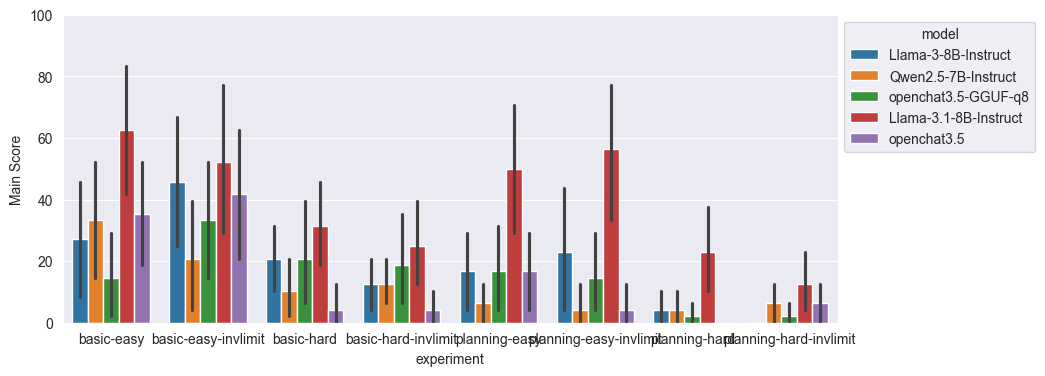

In [279]:
metric_bar_plot(game_df, "Main Score", max_value=100)

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_6268\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


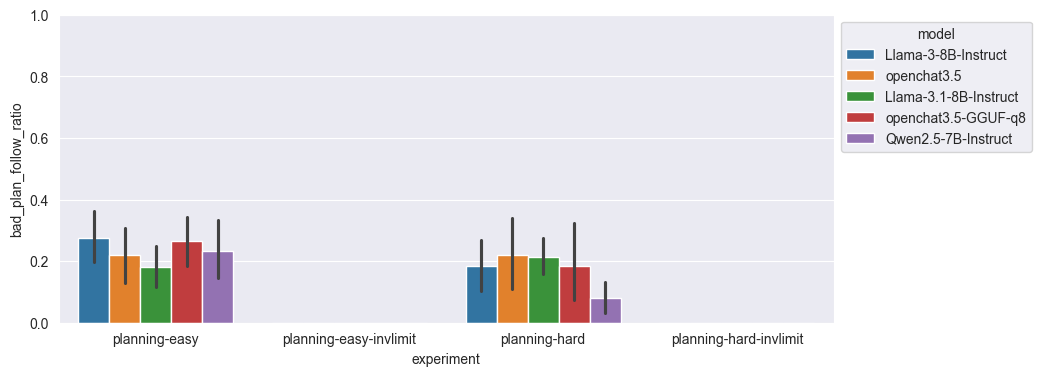

In [280]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_6268\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


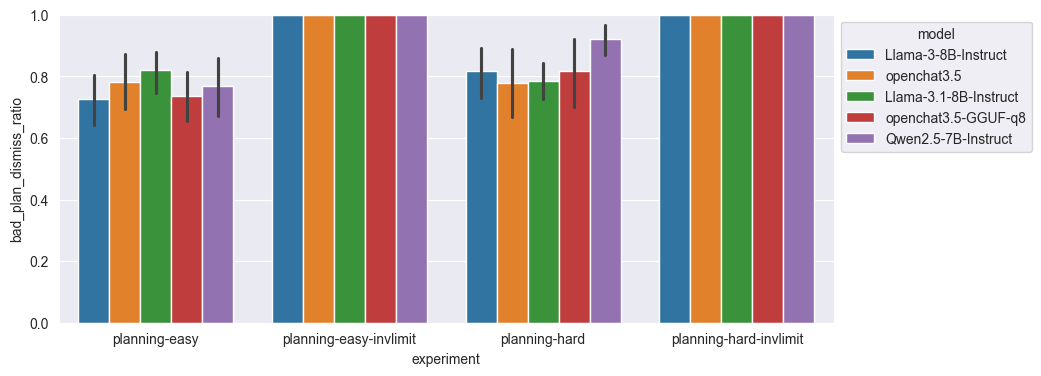

In [281]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_6268\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


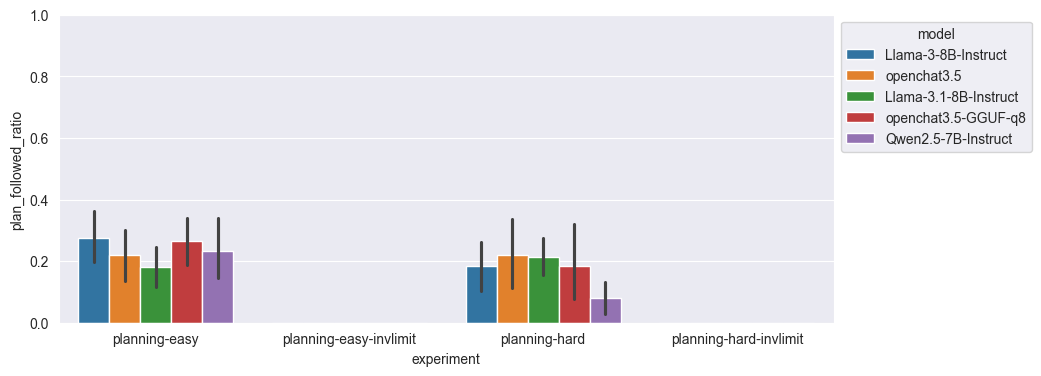

In [282]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_6268\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


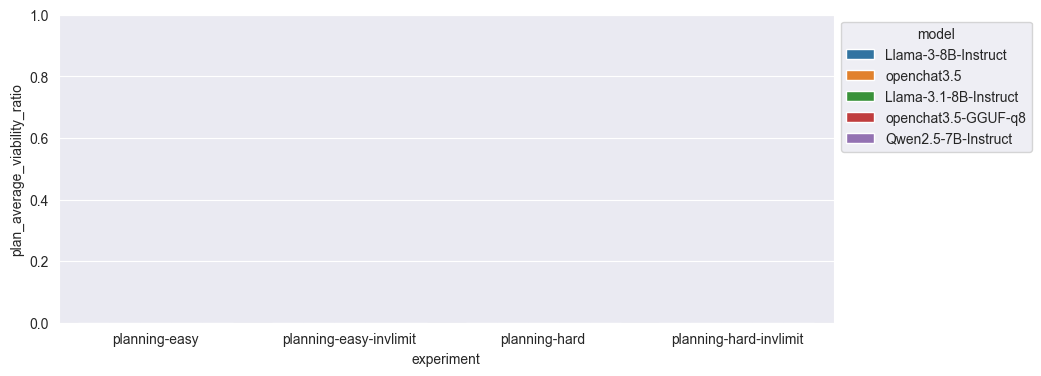

In [283]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")

## Exploration

In [290]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

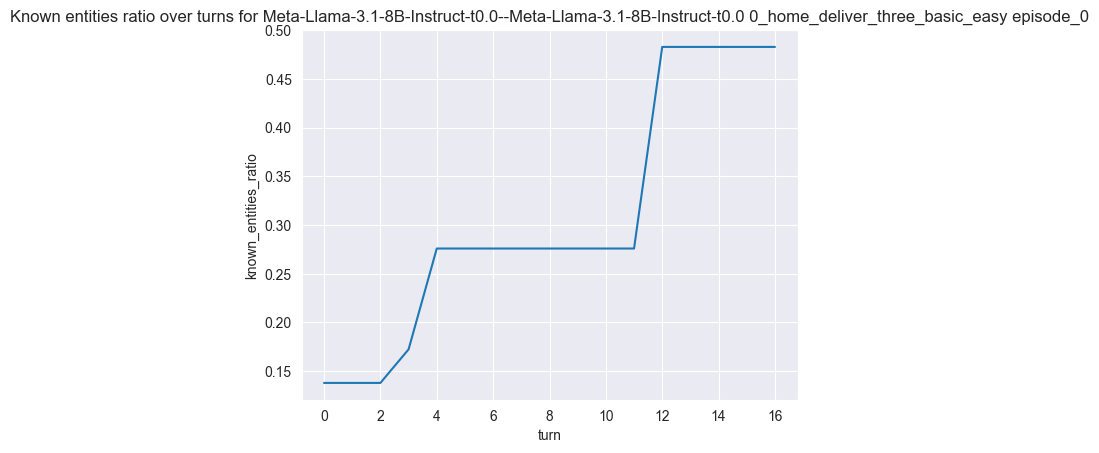

In [292]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [304]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_plan_command_success_ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

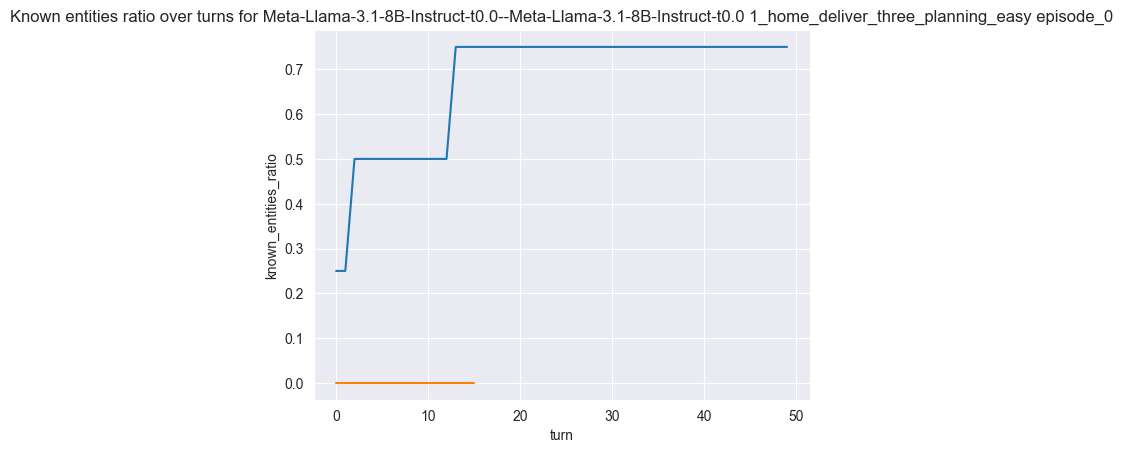

In [305]:
fig, ax = plt.subplots()

ax.plot(turns_known_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [298]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

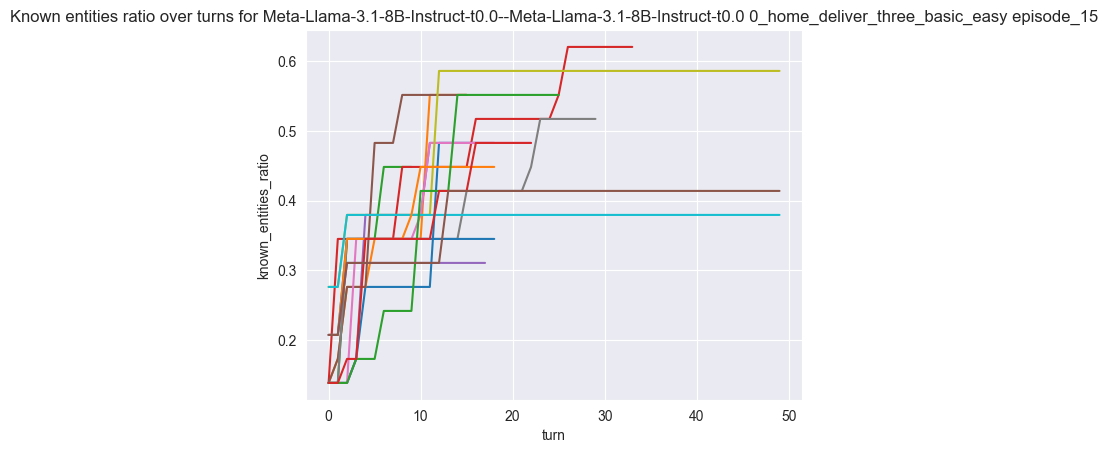

In [299]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

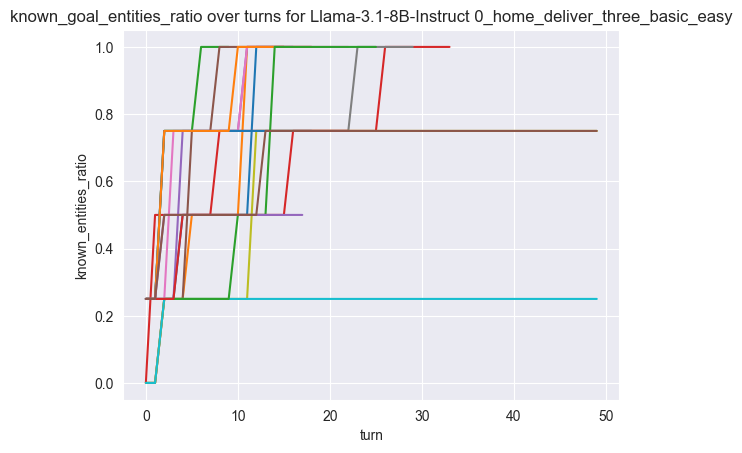

In [302]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()